<a href="https://colab.research.google.com/github/LouisVanLangendonck/UPC-AML-ArchitectureClassif/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Specify here the MAIN DIRECTORY of the project. 

In [ ]:
project_dir = '/content/drive/MyDrive/aml'

## Imports and Preparation

In [ ]:
#@title Imports and connecting to google drive

import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import keras
import random
import pandas as pd
import random
! pip install tensorflow-addons
import tensorflow_addons as tfa

print("TF version:", tf.__version__)
print("keras version:", keras.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.4 MB/s 
TF version: 2.9.2
keras version: 2.9.0
GPU is available
Mounted at /content/drive


Checking if all data is found

In [ ]:
train_data = os.path.join(project_dir,'data/unzipped/train/')
test_data = os.path.join(project_dir,'data/unzipped/test/')
print(os.listdir(train_data))

['gothic', 'baroque', 'modernism', 'contemporary', 'noucentisme', 'renaissance', 'romanesque', 'neoclassicism']


## Train-validation Splitting

Making a 80%-20% stratified train-validation split. This is done by reading image file names into a dataframe and splitting images from this basis. This is done because we want to use the 'flow_from_directory' or 'flow_from_dataframe' functions from keras which are the most efficient way of loading images and as these functions do NOT support stratified/costum splitting and go straight from the directory into model training, this was the only possible approach. Note that just like in train-test splitting, splitting is done PER BUILDING instead of per image as for one building, multiple images can be available which might lead to train-validation leakage.   

In [ ]:
import pandas as pd

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def make_df_train_val_img(train_path, split_size, random_state=1):
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()

    train_list_img = []
    val_list_img = []
    train_list_label = []
    val_list_label = []

    style_paths = listdir_fullpath(train_path)
    for style in style_paths:
        style_name = style.split('/')[-1]
        unique = set()
        for image in os.listdir(style):
          if '.jpg' in image:
            unique.add(image.split('-')[1])
        random.seed(random_state)
        val = random.sample(unique, int(split_size*len(unique)))
        for image in os.listdir(style):
          if '.jpg' in image:
            name = style_name + '/' + image
            if not image.split('-')[1] in val:
              train_list_img.append(name)
              train_list_label.append(style_name)
            else:
              val_list_img.append(name)
              val_list_label.append(style_name)

    train_df['images'] = train_list_img
    train_df['labels'] = train_list_label
    val_df['images'] = val_list_img
    val_df['labels'] = val_list_label
    return train_df, val_df

train_dataframe, val_dataframe = make_df_train_val_img(os.path.join(project_dir,'data/unzipped/train'), 0.2)

Computing Class Weights to use for WCEL (weighted Cross-Entropy Loss)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight ='balanced',classes =np.unique(list(train_dataframe['labels'])),
                                                 y = list(train_dataframe['labels']))

class_weights_dict = {k: v for k, v in enumerate(class_weights)}
class_weights_dict

{0: 0.9989886731391586,
 1: 1.7317671809256663,
 2: 1.4475381008206332,
 3: 0.6088510848126233,
 4: 1.635430463576159,
 5: 0.5810588235294117,
 6: 4.694866920152092,
 7: 0.6481627296587926}

## Defining Dataflow and preparing Models for Top Layer Training. 

Add random data augmentation, only to the training datagenerator! 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  shear_range = 0.3,
                                  zoom_range = 0.3,
                                  horizontal_flip=True, 
                                  preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

The convolutional base that is used for this transfer learning project. 

In [ ]:
from keras.applications import Xception
from keras import layers
from keras import models

conv_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3),
    pooling='avg'
)

The top layer to add on the base and to train as a first step. Note that the parameters are the same as the optimized model from seperate Xception Feature extraction + MLP. 

In [ ]:
model = models.Sequential()
model.add(layers.Dropout(0.5, input_shape=(conv_base.output_shape[1],)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8,activation = 'softmax'))
model.build()

The flows that define how images are loaded in from the directory, through the dataframe, into model training and/or validation. Note the resize to (299,299) format.

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    directory=os.path.join(project_dir,'data/unzipped/train/'),
    x_col="images",
    y_col="labels",
    batch_size=50,
    seed=1,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299))

val_generator=val_datagen.flow_from_dataframe(
    dataframe=val_dataframe,
    directory=os.path.join(project_dir,"data/unzipped/train/"),
    x_col="images",
    y_col="labels",
    batch_size=50,
    seed=1,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299))

nr_of_batches_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
nr_of_val_batches_per_epoch = int(np.ceil(val_generator.samples / val_generator.batch_size))

Found 9878 validated image filenames belonging to 8 classes.
Found 2413 validated image filenames belonging to 8 classes.


Freeze the convolutional base for first model training step! 

In [ ]:
f1 = tfa.metrics.F1Score(8,'weighted')

conv_base_frozen = conv_base
conv_base_frozen.trainable = False

model_ = models.Sequential()
model_.add(conv_base_frozen)
model_.add(model)
model_.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
      loss='categorical_crossentropy',
      metrics=[f1, 'acc'])

model_.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 sequential_5 (Sequential)   (None, 8)                 1053192   
                                                                 
Total params: 21,914,672
Trainable params: 1,053,192
Non-trainable params: 20,861,480
_________________________________________________________________


Top Layer Training!

In [ ]:
model_path = os.path.join(project_dir,'models/transfer_learning/top_layer_training/')

if not os.path.exists(model_path):
    os.makedirs(model_path)

my_callbacks = [
  tf.keras.callbacks.ModelCheckpoint(filepath= model_path + 'model.epo:{epoch:02d}-val_loss:{val_loss:.3f}--.h5', save_weights_only=True,monitor='val_acc'),
  tf.keras.callbacks.ModelCheckpoint(filepath= model_path + 'best_val_acc.h5', save_weights_only=True,save_best_only=True, monitor='val_loss'),
  tf.keras.callbacks.CSVLogger(model_path + 'history.csv', separator=",")
  ]

model_.fit(train_generator, 
            steps_per_epoch=nr_of_batches_per_epoch,
            epochs = 80, 
            validation_data = val_generator, 
            validation_steps = nr_of_val_batches_per_epoch,
            callbacks=my_callbacks, 
            class_weight=class_weights_dict) 

## Retrain all weights on low learning rate

Load in weights of the model with best layer (the model with the lowest validation loss).

In [ ]:
best_top_layer_weights = '/content/drive/MyDrive/aml/models/transfer_learning/top_layer_training/best_val_loss.h5'

Build the model with this optimized layer (so load in the weights) and then unfreeze the whole model. Note the LOWER learning rate to not mess up representations in the convolutional layers.

In [ ]:
conv_base_frozen = conv_base
conv_base_frozen.trainable = False

model_ = models.Sequential()
model_.add(conv_base_frozen)
model_.add(model)
model_.load_weights(best_top_layer_weights)
model_.layers[0].trainable = True
model_.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001),
      loss='categorical_crossentropy',
      metrics=[f1, 'acc'])
        
model_.summary()

Second training round to update weights of all models!!


In [ ]:
model_path = os.path.join(project_dir,'models/transfer_learning/unfrozen_convolutional_training/')

if not os.path.exists(model_path):
    os.makedirs(model_path)

my_callbacks = [
  tf.keras.callbacks.ModelCheckpoint(filepath= model_path + 'model.epo:{epoch:02d}-val_loss:{val_loss:.3f}--.h5', save_weights_only=True,monitor='val_acc'),
  tf.keras.callbacks.ModelCheckpoint(filepath= model_path + 'best_val_loss.h5', save_weights_only=True,save_best_only=True, monitor='val_loss'),
  tf.keras.callbacks.CSVLogger(model_path + 'history.csv', separator=",", append=True)
  ]


nr_of_batches_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
nr_of_val_batches_per_epoch = int(np.ceil(val_generator.samples / val_generator.batch_size))


  model_.fit(train_generator, 
            steps_per_epoch=nr_of_batches_per_epoch,
            epochs = 50, 
            validation_data = val_generator, 
            validation_steps = nr_of_val_batches_per_epoch,
            callbacks=my_callbacks, 
            class_weight=class_weights_dict) 

## Validation Set Performance

To test the performance on the validation set, the best model (lowest loss) is rebuild without the dropout. 

In [ ]:
best_weights = '/content/drive/MyDrive/aml/models/transfer_learning/unfrozen_convolutional_training/best_val_loss.h5'

conv_base.trainable = True
model = models.Sequential()
model.add(layers.Dense(512, activation='relu',input_shape=(conv_base.output_shape[1],)))
model.add(layers.Dense(8,activation = 'softmax'))
model.build()
model_ = models.Sequential()
model_.add(conv_base)
model_.add(model)
model_.load_weights(best_weights)
model_.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001),
      loss='categorical_crossentropy',
      metrics=['acc'])

model_.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 sequential_14 (Sequential)  (None, 8)                 1053192   
                                                                 
Total params: 21,914,672
Trainable params: 21,860,144
Non-trainable params: 54,528
_________________________________________________________________


The validation set images are predicted

In [ ]:
y_true_val = []
y_pred_val = []
for step in range(nr_of_val_batches_per_epoch):
    X_val, y_true = val_generator.next()
    y_true_val.extend(y_true.argmax(axis=1))
    prediction = model_.predict(X_val, verbose=0)
    y_pred_val.extend(prediction.argmax(axis=1))

Functions to pretty print a Confusion Matrix and Classification report for the validation set.

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,f1_score

def pretty_confusion(y_true, y_pred, labels, normalize=True):
  if normalize:
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true')
  else:
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
  fig = plt.figure(figsize=(16, 14))
  ax= plt.subplot()
  if normalize:
    sns.heatmap(cm, annot=True, ax = ax, fmt=".2f", cmap='Blues', annot_kws={
                'fontsize': 16})
  else:
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap='Blues', annot_kws={
                'fontsize': 16})
  # labels, title and ticks
  ax.set_xlabel('Predicted', fontsize=20)
  ax.xaxis.set_label_position('bottom')
  plt.xticks(rotation=90)
  ax.xaxis.set_ticklabels(labels, fontsize = 15)
  ax.xaxis.tick_bottom()

  ax.set_ylabel('True', fontsize=20)
  ax.yaxis.set_ticklabels(labels, fontsize = 15)
  plt.yticks(rotation=0)

  plt.title('Refined Confusion Matrix', fontsize=20)

  plt.show()

def report(y_true_, y_pred_, normalize_conf=True):
    label_list = ['baroque', 'contemporary', 'gothic', 'modernism', 'neoclassicism', 'noucentisme', 'renaissance', 'romanesque']
    print('\nClassification Report\n')
    print(classification_report(y_true_, y_pred_))
    print('More precise macro F1-score: {}'.format(f1_score(y_true_, y_pred_, average='weighted')))
    pretty_confusion(y_true_, y_pred_, label_list, normalize_conf)

Performance on the validation set!


Classification Report

              precision    recall  f1-score   support

           0       0.65      0.70      0.68       289
           1       0.72      0.95      0.82       176
           2       0.63      0.66      0.65       214
           3       0.75      0.66      0.70       468
           4       0.50      0.67      0.57       177
           5       0.77      0.63      0.69       517
           6       0.56      0.93      0.70        76
           7       0.90      0.79      0.84       496

    accuracy                           0.72      2413
   macro avg       0.68      0.75      0.71      2413
weighted avg       0.73      0.72      0.72      2413

More precise macro F1-score: 0.7197144922108012


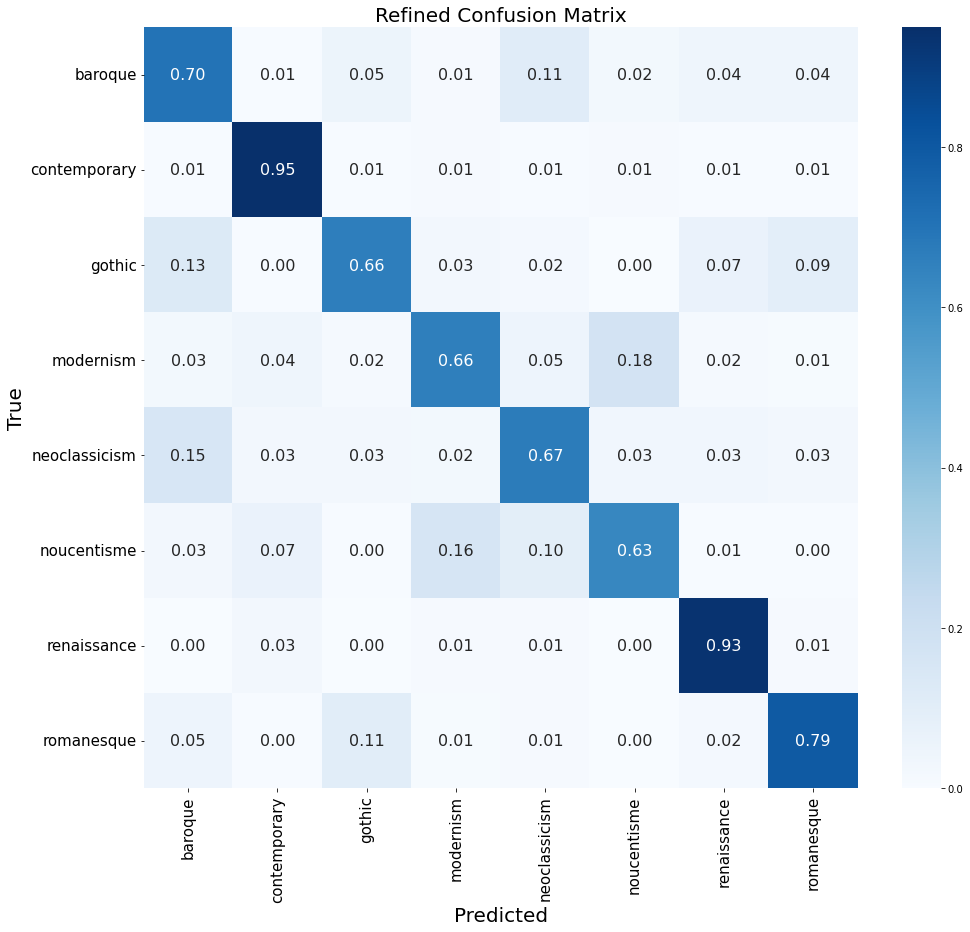

In [ ]:
report(y_true_val, y_pred_val, True)

## Test Set Performance

Now define the test generator dataflow. No need for dataframes, it goes straight from the directory using flow_from_directory. The best model makes its predictions. 

In [ ]:
test_generator=val_datagen.flow_from_directory(
    directory=os.path.join(path_to_aml_file,"data/unzipped/test/"),
    class_mode="categorical",
    target_size=(299,299),
    batch_size=50)

nr_of_test_batches_per_epoch = int(np.ceil(test_generator.samples / test_generator.batch_size))

y_true_test = []
y_pred_test = []
for step in range(nr_of_test_batches_per_epoch):
    X, y_true = test_generator.next()
    y_true_test.extend(y_true.argmax(axis=1))
    prediction = model_.predict(X, verbose=0)
    y_pred_test.extend(prediction.argmax(axis=1))

Found 3135 images belonging to 8 classes.


**Result of final model on the test set!**


Classification Report

              precision    recall  f1-score   support

           0       0.55      0.49      0.52       409
           1       0.60      0.82      0.69       221
           2       0.40      0.47      0.43       264
           3       0.66      0.51      0.57       628
           4       0.27      0.42      0.33       224
           5       0.63      0.56      0.59       695
           6       0.20      0.35      0.26        85
           7       0.81      0.74      0.78       609

    accuracy                           0.57      3135
   macro avg       0.51      0.54      0.52      3135
weighted avg       0.60      0.57      0.58      3135

More precise macro F1-score: 0.5794466164644084


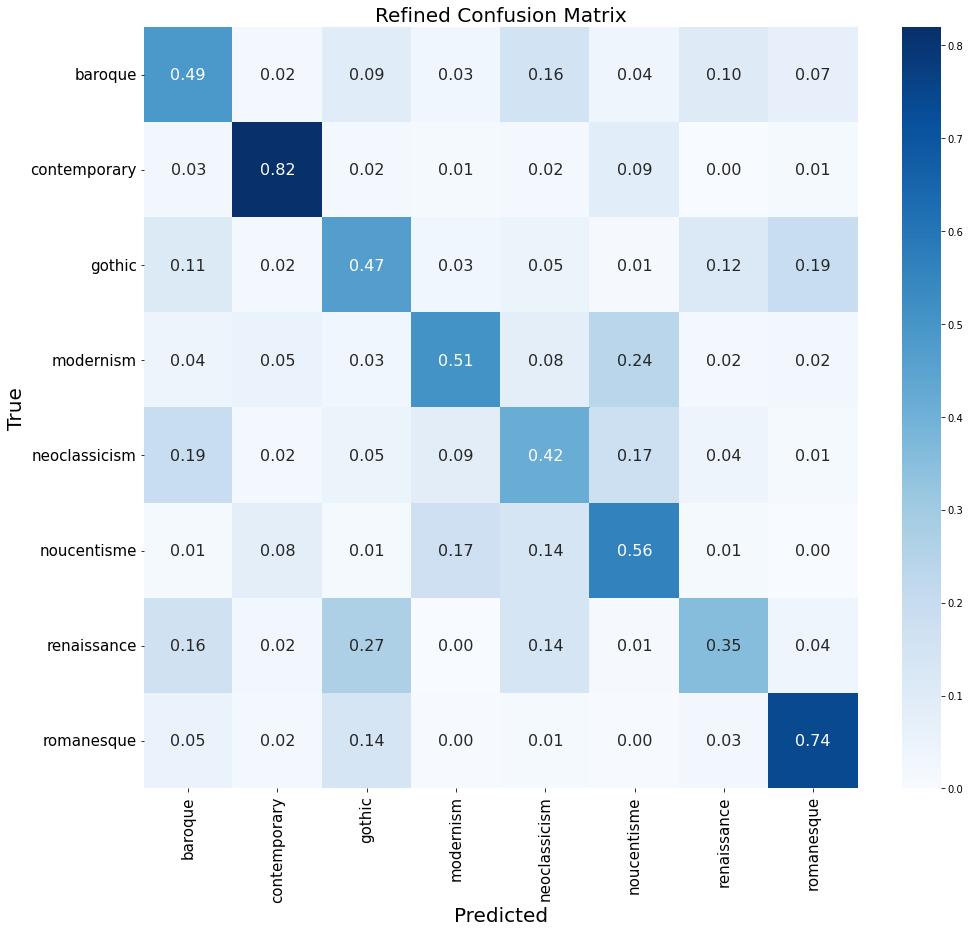

In [ ]:
report(y_true_test, y_pred_test, True)